In [ ]:
import tensorflow as tf
from tensorflow import keras

base_image_path = keras.utils.get_file(
"sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")

style_reference_image_path = keras.utils.get_file(
"starry_night.jpg",
origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

575046/575046 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
943128/943128 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
    image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def content_loss(base_img, combination_img):
  return tf.reduce_sum(tf.square(combination_img - base_img))

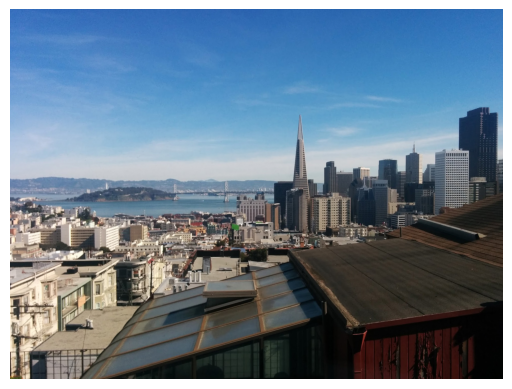

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(keras.utils.load_img(base_image_path))
plt.axis('off')
plt.show()

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def total_variation_loss(x):
    a = tf.square(
    x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
    x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
style_layer_names = [
"block1_conv1",
"block2_conv1",
"block3_conv1",
"block4_conv1",
"block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6

In [ ]:
style_weight = 1e-6
content_weight = 2.5e-8
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
    [base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
      base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
        loss += total_variation_weight * total_variation_loss(combination_image)

    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(
combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
          combination_image, base_image, style_reference_image)
        grads = tape.gradient(loss, combination_image)

    return loss, grads

optimizer = keras.optimizers.SGD(
  keras.optimizers.schedules.ExponentialDecay(
   initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
)

In [ ]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 400, 533, 3))
  warnings.warn(msg)


Iteration 100: loss=17638.26
Iteration 200: loss=15501.61
Iteration 300: loss=14557.03
Iteration 400: loss=14001.21
Iteration 500: loss=13615.68
Iteration 600: loss=13331.51
Iteration 700: loss=13111.04
Iteration 800: loss=12936.13
Iteration 900: loss=12794.75
Iteration 1000: loss=12678.89
Iteration 1100: loss=12582.89
Iteration 1200: loss=12502.63
Iteration 1300: loss=12434.19
Iteration 1400: loss=12373.95
Iteration 1500: loss=12321.13
Iteration 1600: loss=12274.78
Iteration 1700: loss=12233.74
Iteration 1800: loss=12197.37
Iteration 1900: loss=12165.03
Iteration 2000: loss=12135.58
Iteration 2100: loss=12108.94
Iteration 2200: loss=12085.02
Iteration 2300: loss=12063.18
Iteration 2400: loss=12043.18
Iteration 2500: loss=12024.74
Iteration 2600: loss=12007.80
Iteration 2700: loss=11992.22
Iteration 2800: loss=11977.82
Iteration 2900: loss=11964.42
Iteration 3000: loss=11951.84
Iteration 3100: loss=11940.28
Iteration 3200: loss=11929.54
Iteration 3300: loss=11919.47
Iteration 3400: los

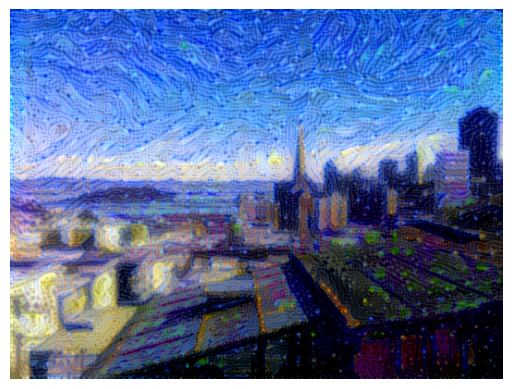

In [ ]:
plt.imshow(keras.utils.load_img("combination_image_at_iteration_4000.png"))
plt.axis('off')
plt.show()